# **Deforum Stable Diffusion (v0.7.1)**
⚠️ **NOTICE: This project is no longer maintained.** ⚠️
This repository is no longer actively maintained or updated. Users are advised to find alternative solutions or fork the project if they wish to continue development.

In [1]:
#@markdown **NVIDIA GPU**
import subprocess, os, sys
sub_p_res = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total,memory.free', '--format=csv,noheader'], stdout=subprocess.PIPE).stdout.decode('utf-8')
print(f"{sub_p_res[:-1]}")

NVIDIA A100-SXM4-40GB, 40960 MiB, 40511 MiB


# Setup

In [2]:
#@markdown **Environment Setup**
import subprocess, time, gc, os, sys

def setup_environment():
    try:
        ipy = get_ipython()
    except:
        ipy = 'could not get_ipython'

    if 'google.colab' in str(ipy):
        start_time = time.time()
        packages = [
            'xformers',
            'einops==0.4.1 pytorch-lightning==2.3.3 torchdiffeq==0.2.3 torchsde==0.2.6',
            'ftfy timm transformers open-clip-torch==2.24.0 omegaconf torchmetrics==0.11.4',
            'safetensors kornia accelerate jsonmerge matplotlib resize-right',
            'scikit-learn numpngw pydantic scikit-image==0.19.3'
        ]
        for package in packages:
            print(f"..installing {package}")
            subprocess.check_call([sys.executable, '-m', 'pip', 'install'] + package.split())
        if not os.path.exists("deforum-stable-diffusion"):
            subprocess.check_call(['git', 'clone', 'https://github.com/deforum-art/deforum-stable-diffusion.git'])
        else:
            print(f"..deforum-stable-diffusion already exists")
        with open('deforum-stable-diffusion/src/k_diffusion/__init__.py', 'w') as f:
            f.write('')
        sys.path.extend(['deforum-stable-diffusion/','deforum-stable-diffusion/src',])
        end_time = time.time()
        print(f"..environment set up in {end_time-start_time:.0f} seconds")
    else:
        sys.path.extend(['src'])
        print("..skipping setup")

setup_environment()

import torch
import random
import clip
from IPython import display
from types import SimpleNamespace
from helpers.save_images import get_output_folder
from helpers.settings import load_args
from helpers.render import render_animation, render_input_video, render_image_batch, render_interpolation
from helpers.model_load import make_linear_decode, load_model, get_model_output_paths
from helpers.aesthetics import load_aesthetics_model
from helpers.prompts import Prompts

..installing xformers
..installing einops==0.4.1 pytorch-lightning==2.3.3 torchdiffeq==0.2.3 torchsde==0.2.6
..installing ftfy timm transformers open-clip-torch==2.24.0 omegaconf torchmetrics==0.11.4
..installing safetensors kornia accelerate jsonmerge matplotlib resize-right
..installing scikit-learn numpngw pydantic scikit-image==0.19.3
..environment set up in 25 seconds


In [3]:
#@markdown **Path Setup**

def PathSetup():
    models_path = "models" #@param {type:"string"}
    configs_path = "configs" #@param {type:"string"}
    output_path = "outputs" #@param {type:"string"}
    mount_google_drive = True #@param {type:"boolean"}
    models_path_gdrive = "/content/drive/MyDrive/AI/models" #@param {type:"string"}
    output_path_gdrive = "/content/drive/MyDrive/AI/StableDiffusion" #@param {type:"string"}
    return locals()

root = SimpleNamespace(**PathSetup())
root.models_path, root.output_path = get_model_output_paths(root)

..error mounting drive or with drive path variables
..reverting to default path variables
models_path: /content/models
output_path: /content/outputs


In [4]:
#@markdown **Model Setup**

def ModelSetup():
    map_location = "cuda" #@param ["cpu", "cuda"]
    model_config = "v1-inference.yaml" #@param ["custom","v2-inference.yaml","v2-inference-v.yaml","v1-inference.yaml"]
    model_checkpoint =  "Protogen_V2.2.ckpt" #@param ["custom","v2-1_768-ema-pruned.ckpt","v2-1_512-ema-pruned.ckpt","768-v-ema.ckpt","512-base-ema.ckpt","Protogen_V2.2.ckpt","v1-5-pruned.ckpt","v1-5-pruned-emaonly.ckpt","sd-v1-4-full-ema.ckpt","sd-v1-4.ckpt","sd-v1-3-full-ema.ckpt","sd-v1-3.ckpt","sd-v1-2-full-ema.ckpt","sd-v1-2.ckpt","sd-v1-1-full-ema.ckpt","sd-v1-1.ckpt", "robo-diffusion-v1.ckpt","wd-v1-3-float16.ckpt"]
    custom_config_path = "" #@param {type:"string"}
    custom_checkpoint_path = "" #@param {type:"string"}
    return locals()

root.__dict__.update(ModelSetup())
root.model, root.device = load_model(root, load_on_run_all=True, check_sha256=True, map_location=root.map_location)

..attempting to download Protogen_V2.2.ckpt...this may take a while


Protogen_V2.2.ckpt: 100%|██████████| 4.27G/4.27G [00:56<00:00, 74.9MB/s]


config_path: /content/deforum-stable-diffusion/configs/v1-inference.yaml
ckpt_path: /content/models/Protogen_V2.2.ckpt
..checking sha256
..hash is correct
..loading model


/content/deforum-stable-diffusion/helpers/model_load.py:230: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pl_sd = torch.load(ckpt, map_location=map_location)
Traceback (mos

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

# Settings

In [16]:
def DeforumAnimArgs():

    #@markdown ####**Animation:**
    animation_mode = 'Video Input' #@param ['None', '2D', '3D', 'Video Input', 'Interpolation'] {type:'string'}
    max_frames = 1000 #@param {type:"number"}
    border = 'replicate' #@param ['wrap', 'replicate'] {type:'string'}

    #@markdown ####**Motion Parameters:**
    angle = "0:(0)"#@param {type:"string"}
    zoom = "0:(1.04)"#@param {type:"string"}
    translation_x = "0:(10*sin(2*3.14*t/10))"#@param {type:"string"}
    translation_y = "0:(0)"#@param {type:"string"}
    translation_z = "0:(10)"#@param {type:"string"}
    rotation_3d_x = "0:(0)"#@param {type:"string"}
    rotation_3d_y = "0:(0)"#@param {type:"string"}
    rotation_3d_z = "0:(0)"#@param {type:"string"}
    flip_2d_perspective = False #@param {type:"boolean"}
    perspective_flip_theta = "0:(0)"#@param {type:"string"}
    perspective_flip_phi = "0:(t%15)"#@param {type:"string"}
    perspective_flip_gamma = "0:(0)"#@param {type:"string"}
    perspective_flip_fv = "0:(53)"#@param {type:"string"}
    noise_schedule = "0: (0.02)"#@param {type:"string"}
    strength_schedule = "0: (0.65)"#@param {type:"string"}
    contrast_schedule = "0: (1.0)"#@param {type:"string"}
    hybrid_comp_alpha_schedule = "0:(1)" #@param {type:"string"}
    hybrid_comp_mask_blend_alpha_schedule = "0:(0.5)" #@param {type:"string"}
    hybrid_comp_mask_contrast_schedule = "0:(1)" #@param {type:"string"}
    hybrid_comp_mask_auto_contrast_cutoff_high_schedule =  "0:(100)" #@param {type:"string"}
    hybrid_comp_mask_auto_contrast_cutoff_low_schedule =  "0:(0)" #@param {type:"string"}

    #@markdown ####**Sampler Scheduling:**
    enable_schedule_samplers = False #@param {type:"boolean"}
    sampler_schedule = "0:('euler'),10:('dpm2'),20:('dpm2_ancestral'),30:('heun'),40:('euler'),50:('euler_ancestral'),60:('dpm_fast'),70:('dpm_adaptive'),80:('dpmpp_2s_a'),90:('dpmpp_2m')" #@param {type:"string"}

    #@markdown ####**Unsharp mask (anti-blur) Parameters:**
    kernel_schedule = "0: (5)"#@param {type:"string"}
    sigma_schedule = "0: (1.0)"#@param {type:"string"}
    amount_schedule = "0: (0.2)"#@param {type:"string"}
    threshold_schedule = "0: (0.0)"#@param {type:"string"}

    #@markdown ####**Coherence:**
    color_coherence = 'Match Frame 0 LAB' #@param ['None', 'Match Frame 0 HSV', 'Match Frame 0 LAB', 'Match Frame 0 RGB', 'Video Input'] {type:'string'}
    color_coherence_video_every_N_frames = 1 #@param {type:"integer"}
    color_force_grayscale = False #@param {type:"boolean"}
    diffusion_cadence = '1' #@param ['1','2','3','4','5','6','7','8'] {type:'string'}

    #@markdown ####**3D Depth Warping:**
    use_depth_warping = True #@param {type:"boolean"}
    midas_weight = 0.3#@param {type:"number"}
    near_plane = 200
    far_plane = 10000
    fov = 40#@param {type:"number"}
    padding_mode = 'border'#@param ['border', 'reflection', 'zeros'] {type:'string'}
    sampling_mode = 'bicubic'#@param ['bicubic', 'bilinear', 'nearest'] {type:'string'}
    save_depth_maps = False #@param {type:"boolean"}

    #@markdown ####**Video Input:**
    video_init_path ='/content/---_2 (2).mp4'#@param {type:"string"}
    extract_nth_frame = 50#@param {type:"number"}
    overwrite_extracted_frames = True #@param {type:"boolean"}
    use_mask_video = False #@param {type:"boolean"}
    video_mask_path ='/content/video_in.mp4'#@param {type:"string"}

    #@markdown ####**Hybrid Video for 2D/3D Animation Mode:**
    hybrid_generate_inputframes = False #@param {type:"boolean"}
    hybrid_use_first_frame_as_init_image = True #@param {type:"boolean"}
    hybrid_motion = "None" #@param ['None','Optical Flow','Perspective','Affine']
    hybrid_motion_use_prev_img = False #@param {type:"boolean"}
    hybrid_flow_method = "DIS Medium" #@param ['DenseRLOF','DIS Medium','Farneback','SF']
    hybrid_composite = False #@param {type:"boolean"}
    hybrid_comp_mask_type = "None" #@param ['None', 'Depth', 'Video Depth', 'Blend', 'Difference']
    hybrid_comp_mask_inverse = False #@param {type:"boolean"}
    hybrid_comp_mask_equalize = "None" #@param  ['None','Before','After','Both']
    hybrid_comp_mask_auto_contrast = False #@param {type:"boolean"}
    hybrid_comp_save_extra_frames = False #@param {type:"boolean"}
    hybrid_use_video_as_mse_image = False #@param {type:"boolean"}

    #@markdown ####**Interpolation:**
    interpolate_key_frames = False #@param {type:"boolean"}
    interpolate_x_frames = 20 #@param {type:"number"}

    #@markdown ####**Resume Animation:**
    resume_from_timestring = False #@param {type:"boolean"}
    resume_timestring = "20220829210106" #@param {type:"string"}

    return locals()

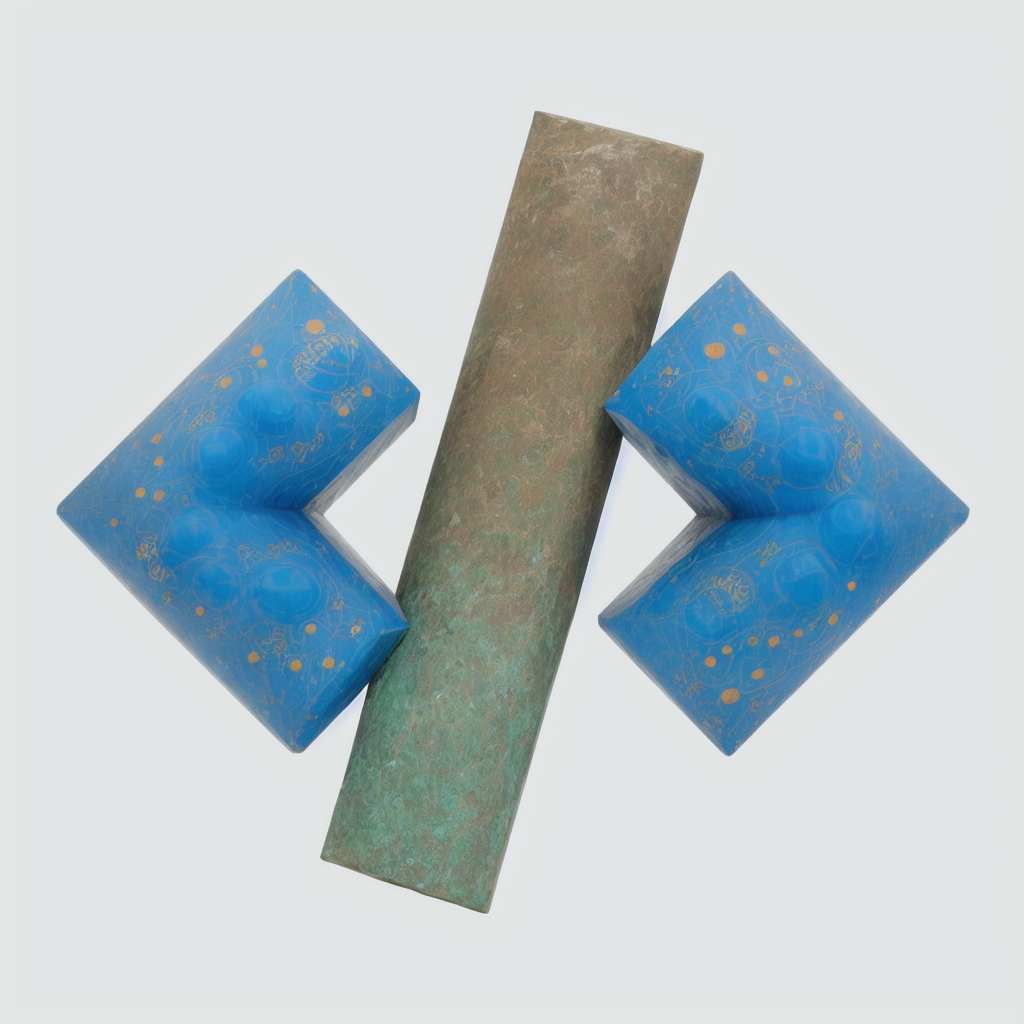

In [17]:
#@markdown **Load Settings**
override_settings_with_file = False #@param {type:"boolean"}
settings_file = "custom" #@param ["custom", "512x512_aesthetic_0.json","512x512_aesthetic_1.json","512x512_colormatch_0.json","512x512_colormatch_1.json","512x512_colormatch_2.json","512x512_colormatch_3.json"]
custom_settings_file = "/content/20231025054638_settings.txt"#@param {type:"string"}

def DeforumArgs():
    #@markdown **Image Settings**
    W = 1024 #@param
    H = 1024 #@param
    W, H = map(lambda x: x - x % 64, (W, H))  # resize to integer multiple of 64
    bit_depth_output = 8 #@param [8, 16, 32] {type:"raw"}

    #@markdown **Sampling Settings**
    seed = -1 #@param
    sampler = 'dpmpp_2s_a' #@param ["klms","dpm2","dpm2_ancestral","heun","euler","euler_ancestral","plms", "ddim", "dpm_fast", "dpm_adaptive", "dpmpp_2s_a", "dpmpp_2m"]
    steps = 50 #@param
    scale = 5 #@param
    ddim_eta = 0.0 #@param
    dynamic_threshold = None
    static_threshold = None

    #@markdown **Save & Display Settings**
    save_samples = True #@param {type:"boolean"}
    save_settings = True #@param {type:"boolean"}
    display_samples = True #@param {type:"boolean"}
    save_sample_per_step = False #@param {type:"boolean"}
    show_sample_per_step = False #@param {type:"boolean"}

    #@markdown **Batch Settings**
    n_batch = 1 #@param
    n_samples = 1 #@param
    batch_name = "NewYorker_Code_31_Neutral" #@param {type:"string"}
    filename_format = "{timestring}_{index}_{prompt}.png" #@param ["{timestring}_{index}_{seed}.png","{timestring}_{index}_{prompt}.png"]
    seed_behavior = "ladder" #@param ["iter","fixed","random","ladder","alternate"]
    seed_iter_N = 1 #@param {type:'integer'}
    make_grid = False #@param {type:"boolean"}
    grid_rows = 2 #@param
    outdir = get_output_folder(root.output_path, batch_name)

    #@markdown **Init Settings**
    use_init = False #@param {type:"boolean"}
    strength = 0.5 #@param {type:"number"}
    strength_0_no_init = True # Set the strength to 0 automatically when no init image is used
    init_image = "https://cdn.pixabay.com/photo/2022/07/30/13/10/green-longhorn-beetle-7353749_1280.jpg" #@param {type:"string"}
    add_init_noise = False #@param {type:"boolean"}
    init_noise = 0.05 #@param
    # Whiter areas of the mask are areas that change more
    use_mask = False #@param {type:"boolean"}
    use_alpha_as_mask = False # use the alpha channel of the init image as the mask
    mask_file = "https://www.filterforge.com/wiki/images/archive/b/b7/20080927223728%21Polygonal_gradient_thumb.jpg" #@param {type:"string"}
    invert_mask = False #@param {type:"boolean"}
    # Adjust mask image, 1.0 is no adjustment. Should be positive numbers.
    mask_brightness_adjust = 1.0  #@param {type:"number"}
    mask_contrast_adjust = 1.0  #@param {type:"number"}
    # Overlay the masked image at the end of the generation so it does not get degraded by encoding and decoding
    overlay_mask = True  # {type:"boolean"}
    # Blur edges of final overlay mask, if used. Minimum = 0 (no blur)
    mask_overlay_blur = 5 # {type:"number"}

    #@markdown **Exposure/Contrast Conditional Settings**
    mean_scale = 0 #@param {type:"number"}
    var_scale = 0 #@param {type:"number"}
    exposure_scale = 0 #@param {type:"number"}
    exposure_target = 0.5 #@param {type:"number"}

    #@markdown **Color Match Conditional Settings**
    colormatch_scale = 0 #@param {type:"number"}
    colormatch_image = "https://www.saasdesign.io/wp-content/uploads/2021/02/palette-3-min-980x588.png" #@param {type:"string"}
    colormatch_n_colors = 4 #@param {type:"number"}
    ignore_sat_weight = 0 #@param {type:"number"}

    #@markdown **CLIP\Aesthetics Conditional Settings**
    clip_name = 'ViT-L/14' #@param ['ViT-L/14', 'ViT-L/14@336px', 'ViT-B/16', 'ViT-B/32']
    clip_scale = 0 #@param {type:"number"}
    aesthetics_scale = 0 #@param {type:"number"}
    cutn = 1 #@param {type:"number"}
    cut_pow = 0.0001 #@param {type:"number"}

    #@markdown **Other Conditional Settings**
    init_mse_scale = 0 #@param {type:"number"}
    init_mse_image = "https://cdn.pixabay.com/photo/2022/07/30/13/10/green-longhorn-beetle-7353749_1280.jpg" #@param {type:"string"}
    blue_scale = 0 #@param {type:"number"}

    #@markdown **Conditional Gradient Settings**
    gradient_wrt = 'x0_pred' #@param ["x", "x0_pred"]
    gradient_add_to = 'both' #@param ["cond", "uncond", "both"]
    decode_method = 'linear' #@param ["autoencoder","linear"]
    grad_threshold_type = 'dynamic' #@param ["dynamic", "static", "mean", "schedule"]
    clamp_grad_threshold = 0.2 #@param {type:"number"}
    clamp_start = 0.2 #@param
    clamp_stop = 0.01 #@param
    grad_inject_timing = list(range(1,10)) #@param

    #@markdown **Speed vs VRAM Settings**
    cond_uncond_sync = True #@param {type:"boolean"}
    precision = 'autocast'
    C = 4
    f = 8

    cond_prompt = ""
    cond_prompts = ""
    uncond_prompt = ""
    uncond_prompts = ""
    timestring = ""
    init_latent = None
    init_sample = None
    init_sample_raw = None
    mask_sample = None
    init_c = None
    seed_internal = 0

    return locals()

args_dict = DeforumArgs()
anim_args_dict = DeforumAnimArgs()

if override_settings_with_file:
    load_args(args_dict, anim_args_dict, settings_file, custom_settings_file, verbose=False)

args = SimpleNamespace(**args_dict)
anim_args = SimpleNamespace(**anim_args_dict)

args.timestring = time.strftime('%Y%m%d%H%M%S')
args.strength = max(0.0, min(1.0, args.strength))

# Load clip model if using clip guidance
if (args.clip_scale > 0) or (args.aesthetics_scale > 0):
    root.clip_model = clip.load(args.clip_name, jit=False)[0].eval().requires_grad_(False).to(root.device)
    if (args.aesthetics_scale > 0):
        root.aesthetics_model = load_aesthetics_model(args, root)

if args.seed == -1:
    args.seed = random.randint(0, 2**32 - 1)
if not args.use_init:
    args.init_image = None
if args.sampler == 'plms' and (args.use_init or anim_args.animation_mode != 'None'):
    print(f"Init images aren't supported with PLMS yet, switching to KLMS")
    args.sampler = 'klms'
if args.sampler != 'ddim':
    args.ddim_eta = 0

if anim_args.animation_mode == 'None':
    anim_args.max_frames = 1
elif anim_args.animation_mode == 'Video Input':
    args.use_init = True

# clean up unused memory
gc.collect()
torch.cuda.empty_cache()

# get prompts
cond, uncond = Prompts(prompt=prompts,neg_prompt=neg_prompts).as_dict()

# dispatch to appropriate renderer
if anim_args.animation_mode == '2D' or anim_args.animation_mode == '3D':
    render_animation(root, anim_args, args, cond, uncond)
elif anim_args.animation_mode == 'Video Input':
    render_input_video(root, anim_args, args, cond, uncond)
elif anim_args.animation_mode == 'Interpolation':
    render_interpolation(root, anim_args, args, cond, uncond)
else:
    render_image_batch(root, args, cond, uncond)

In [19]:
prompts = {
    # Early Human History to Age of Exploration (1-13)
    1: "Primitive tribes around campfires, narrating tales of myths, gods, and the mysteries of the cosmos in the style of Moebius",
    3: "Ancient river civilizations constructing towering ziggurats and pyramids, with priests observing celestial events in the style of Moebius",
    5: "Grecian city-states with marble columns, in the style of Moebius",
    7: "The Silk Road bustling with traders, camels, and caravans, exchanging goods, cultures, and ideas across vast deserts in the style of Moebius",
    9: "Medieval kingdoms with towering castles and fortified walls, knights jousting and minstrels singing tales of valor in the style of Moebius",
    13: "Port cities with shipyards, as navigators prepare caravels, studying charts and compasses, eager to explore unknown seas in the style of Moebius",

    # Transition from Exploration to Industrial Age (13-25)
    15: "Colonial ships reaching new shores, establishing outposts and trading spices, gold, and stories, in the style of Moebius",
    17: "Intricate maps and globes in scholars' chambers, detailing newfound territories and plotting uncharted waters, in the style of Moebius",
    19: "Astronomers in observatories, peering through telescopes, charting the heavens and redefining humanity's place in the universe, in the style of Moebius",
    21: "The Enlightenment era, with thinkers in coffeehouses discussing democracy, science, and the human spirit, in the style of Moebius",
    23: "Revolutionary fervor sweeping across continents, with people marching for freedom, rights, and new societal orders, in the style of Moebius",
    25: "The dawn of the railway age, with steam-powered locomotives crossing vast landscapes, bringing distant lands closer, in the style of Moebius",

    # Industrial Eras (25-38)
    27: "Bustling factories with steam engines, workers operating looms and machinery, signaling the dawn of industrialization, in the style of Moebius",
    29: "Inventors in cluttered workshops, tinkering with early prototypes of the telegraph and phonograph, in the style of Moebius",
    31: "Victorian city streets illuminated by gas lamps, horse-drawn trams and the first automobiles setting the pace, in the style of Moebius",
    33: "Engineers constructing towering bridges and vast railways, connecting continents and fostering trade, in the style of Moebius",
    35: "Early aviators in leather helmets, testing biplanes and dreaming of conquering the skies, in the style of Moebius",
    38: "Grand world fairs showcasing innovations in electricity, moving pictures, and emerging technologies, in the style of Moebius",

    # Digital Eras (38-50)
    40: "Basements filled with the hum of large mainframe computers, punch cards being fed into machines, in the style of Moebius",
    42: "Youth in arcades, engrossed in video games, tokens clinking and synthesized music in the air, in the style of Moebius",
    44: "Tech enthusiasts in home offices, exploring the digital world through early personal computers and modems, in the style of Moebius",
    46: "The birth of the internet, visualized as a sprawling digital city with data highways and glowing nodes, in the style of Moebius",
    50: "People around the globe connected through smartphones, in the style of Moebius",

    # Current AI Era (50-63)
    52: "Modern cities with AI-driven traffic systems, drones delivering packages, and holographic ads lighting up the skyline, in the style of Moebius",
    54: "Researchers in state-of-the-art labs, training neural networks and pioneering breakthroughs in AI, in the style of Moebius",
    56: "Interactive AI classrooms, where holographic teachers and virtual field trips revolutionize education, in the style of Moebius",
    58: "Medical facilities using AI for precision surgeries, and virtual health assistants providing care, in the style of Moebius",
    63: "Humans and AI collaborating in art studios, co-creating music, paintings, and literature, in the style of Moebius",

    # Future Crazy Era (63-75)
    65: "Lush vertical forests in sprawling megacities, maintained by AI ecologists, purifying the air, in the style of Moebius",
    67: "Interstellar train stations, with AI-guided spaceships ferrying passengers to exotic planets, in the style of Moebius",
    69: "Deep-sea colonies powered by AI, where bioluminescent technologies and marine life coexist harmoniously, in the style of Moebius",
    71: "AI philosophers in ethereal realms, pondering existence and the next evolution of consciousness, in the style of Moebius",
    75: "A cosmic dance at the edge of the universe, where AI entities and organic beings celebrate the infinite cycle of creation, in the style of Moebius"
}


In [6]:
prompts = {
    # Early Human History to Age of Exploration (1-13)
    1: "Primitive tribes around campfires, narrating tales of myths, gods, and the mysteries of the cosmos in the style of Moebius",

    # Transition from Exploration to Industrial Age (13-25)
    15: "Colonial ships reaching new shores, establishing outposts and trading spices, gold, and stories, in the style of Moebius",

    # Industrial Eras (25-38)
    27: "Bustling factories with steam engines, workers operating looms and machinery, signaling the dawn of industrialization, in the style of Moebius",

    # Digital Eras (38-50)
    40: "Basements filled with the hum of large mainframe computers, punch cards being fed into machines, in the style of Moebius",

    # Current AI Era (50-63)
    52: "Modern cities with AI-driven traffic systems, drones delivering packages, and holographic ads lighting up the skyline, in the style of Moebius",

    # Future Crazy Era (63-75)
    65: "Lush vertical forests in sprawling megacities, maintained by AI ecologists, purifying the air, in the style of Moebius",
}


In [12]:
prompts = {
    # PREHISTORY (1–15)
    1:  "In dawn-lit grasslands, early hominids chip flint tools, sparks of innovation dancing in the style of Moebius",
    2:  "Primitive shelters of branches and hides, children learning to craft stone blades near a winding river, in the style of Moebius",
    3:  "A tribe gathers around a glowing fire, awe shaping their faces as they first harness its warmth, in the style of Moebius",
    4:  "Hunters crouched in tall savanna grasses, spears poised, silhouettes against a vast orange sun, in the style of Moebius",
    5:  "Rock paintings come alive on canyon walls, storytelling through figures with bows and carved symbols, in the style of Moebius",
    6:  "Early shamans pounding drums, channeling cosmic rhythms by moonlight, the first spiritual tools of humanity, in the style of Moebius",
    7:  "Bison hides stretched on wooden frames, smokehouses and the hum of ancient songs in a valley settlement, in the style of Moebius",
    8:  "Inventive hands shaping bone needles, sewing furs to shield from icy winds, each stitch a step forward, in the style of Moebius",
    9:  "Ceremonial circles of stone, ancestors gathering to mark celestial events in archaic rituals, in the style of Moebius",
    10: "Early gardens in forest clearings, mortars grinding grains, the dawn of agriculture, in the style of Moebius",
    11: "Clay pots fired in rudimentary kilns, their swirling designs a reflection of communal identity, in the style of Moebius",
    12: "Village elders teaching flint-knapping techniques, stone shards gleaming like crystals of possibility, in the style of Moebius",
    13: "Paleolithic art etched into bone, depicting hunts, migrations, and cosmic wonders in swirling lines, in the style of Moebius",
    14: "Footprints crossing a sandy expanse, families migrating to fertile horizons, carrying stone axes and hope, in the style of Moebius",
    15: "Primitive huts and small fields glimmer under starlight, the first settled communities forging a new way of life, in the style of Moebius",

    # EARLY CIVILIZATIONS (16–30)
    16: "Sun-baked riverbanks where people mold bricks, erecting mud-brick walls for the first towns, in the style of Moebius",
    17: "Emerging city-states by the Euphrates, bustling bazaars with reed baskets and handcrafted pottery, in the style of Moebius",
    18: "Grand ziggurats looming over flat plains, priests charting stars from terraced rooftops, in the style of Moebius",
    19: "Scribes pressing reed styluses into clay tablets, capturing daily life and legends, in the style of Moebius",
    20: "Bronze-smiths forging new metals, sparks dancing as they unveil shimmering blades, in the style of Moebius",
    21: "Cedar ships navigating a wide river, laden with grains, textiles, and the seeds of cultural exchange, in the style of Moebius",
    22: "Stepped pyramids crowned by ceremonies of incense, chanting crowds echoing in carved corridors, in the style of Moebius",
    23: "Engineers diverting rivers into irrigation channels, taming nature for thriving farmlands, in the style of Moebius",
    24: "Palaces filled with painted frescoes, retelling mythic heroics and solar deities, in the style of Moebius",
    25: "Merchants weighing precious metals on bronze scales, hammering out the earliest coins, in the style of Moebius",
    26: "Harbors humming with cargo vessels, sails snapping in the wind as explorers journey across unknown seas, in the style of Moebius",
    27: "Walled cities with intricate gates, watchmen scanning distant dunes for caravans of exotic wares, in the style of Moebius",
    28: "Towering obelisks carved with hieroglyphs, priests performing rites amid swirling incense, in the style of Moebius",
    29: "Celestial observations from temple roofs, star charts illuminated by oil lamps, forging mathematics and calendars, in the style of Moebius",
    30: "Ancient libraries brimming with scrolls, knowledge meticulously archived as civilizations flourish, in the style of Moebius",

    # CLASSICAL EMPIRES (31–45)
    31: "Marbled columns under radiant skies, philosophers debating by colonnades, forging logic and reason, in the style of Moebius",
    32: "The roar of an amphitheater, drama performed under torchlight, echoing the complexity of the human soul, in the style of Moebius",
    33: "Greek sculptors chiseling gods and heroes, timeless forms hinting at new frontiers of thought, in the style of Moebius",
    34: "Roman engineers spanning valleys with arched aqueducts, water flowing seamlessly into distant cities, in the style of Moebius",
    35: "Soldiers on cobblestone roads, linking continents with trade routes that shimmer in the midday sun, in the style of Moebius",
    36: "Workshops forging bronze helmets and gladii, each clang of metal echoing through empire-building hearts, in the style of Moebius",
    37: "A lavish banquet in a Roman villa, mosaic floors depicting mythic quests, in the style of Moebius",
    38: "Philosophers translating ancient texts, libraries bridging East and West with shared wisdom, in the style of Moebius",
    39: "Markets filled with olive oil, silks, exotic spices, bound by the bustling energy of global trade, in the style of Moebius",
    40: "Astronomers charting planets from the Library of Alexandria, cosmic diagrams swirling into infinite fractals, in the style of Moebius",
    41: "Alchemists testing minerals, seeking secrets of transformation in candlelit laboratories, in the style of Moebius",
    42: "Caravans crossing wind-sculpted deserts, forging alliances through shared knowledge and commerce, in the style of Moebius",
    43: "Imperial fleets cresting the Mediterranean, exploring distant shores in sleek galleys, in the style of Moebius",
    44: "Mighty coliseums hosting grand spectacles, chariots racing under thunderous applause, in the style of Moebius",
    45: "Royal courts embracing new religions and philosophies, weaving multicultural tapestries of belief, in the style of Moebius",

    # MEDIEVAL AGE (46–60)
    46: "Towering castle walls under a starlit sky, torches flickering as sentries keep watch, in the style of Moebius",
    47: "Knights training in courtyards, their armor catching hints of dawn as swords clash in ceremonial duels, in the style of Moebius",
    48: "Gothic cathedrals reaching toward heaven, stained-glass windows casting kaleidoscopic light, in the style of Moebius",
    49: "Monasteries perched on misty cliffs, monks illuminating manuscripts with gilded leaves, in the style of Moebius",
    50: "Merchants spreading exotic wares along cobblestone streets, caravans from the Silk Road meeting European traders, in the style of Moebius",
    51: "Medieval forges with molten metal, blacksmiths hammering swords and horseshoes, sparks dancing in warm ember-light, in the style of Moebius",
    52: "Feudal courts hosting troubadours, lutes strumming tales of chivalry and hidden wonders, in the style of Moebius",
    53: "Apothecaries blending herbs in cramped wooden shops, mortar and pestle conjuring faint aromatic vapors, in the style of Moebius",
    54: "Crowded docks along stone quays, tall-masted ships braving stormy seas to unearth new lands, in the style of Moebius",
    55: "Medieval universities emerging, students huddled over parchment scrolls, rediscovering ancient texts, in the style of Moebius",
    56: "Clock towers chiming above bustling market squares, heralding a new age of mechanical precision, in the style of Moebius",
    57: "Alchemists designing rudimentary lenses, glimpsing the microscopic dance of life for the first time, in the style of Moebius",
    58: "Village festivals with spinning wheels and laughter, peasants weaving and forging simpler everyday tools, in the style of Moebius",
    59: "Clergy fervently copying sacred texts, each stroke bridging centuries of religious devotion, in the style of Moebius",
    60: "Cartographers sketching lands beyond known frontiers, maps unfurled in candlelit rooms, in the style of Moebius",

    # AGE OF EXPLORATION (61–75)
    61: "Harbors alive with caravels and galleons, explorers charting unknown seas by sextant and starlight, in the style of Moebius",
    62: "Sailors hoisting fluttering sails, the horizon shimmering with promise of hidden continents, in the style of Moebius",
    63: "Navigator's cabin overflowing with compasses, astrolabes, and the hum of new frontiers calling, in the style of Moebius",
    64: "Indigenous villages encountering foreign sails on the shoreline, cultural exchange both wondrous and tense, in the style of Moebius",
    65: "Renaissance workshops unveiling telescopes and anatomically correct sketches, bridging art and science, in the style of Moebius",
    66: "Courtly gatherings marveling at exotic spices, silks, and curious beasts brought back from distant voyages, in the style of Moebius",
    67: "Grand masters painting illusions of depth and perspective, capturing the human form in luminous strokes, in the style of Moebius",
    68: "Inventors testing early printing presses, the rattle of movable type echoing infinite possibilities, in the style of Moebius",
    69: "Royal patrons funding epic expeditions, enthralled by tales of golden cities beyond the horizon, in the style of Moebius",
    70: "Alchemy evolving into modern chemistry, glass beakers reflecting flickers of scientific wonder, in the style of Moebius",
    71: "Philosophers challenging old doctrines, coffeehouses brimming with radical ideas, in the style of Moebius",
    72: "Celestial watchers charting the solar system anew, unraveling the dance of planets, in the style of Moebius",
    73: "Sea charts intricately inscribed with sea monsters and wind roses, capturing humanity’s thirst for the unknown, in the style of Moebius",
    74: "Missionaries learning native tongues, bridging worlds through shared stories and beliefs, in the style of Moebius",
    75: "Port towns alive with cultural fusion, diverse songs blending in narrow alleys and open-air markets, in the style of Moebius",

    # INDUSTRIAL REVOLUTION (76–90)
    76: "Blackened skies above bustling factories, steam engines chugging as spinning gears transform daily life, in the style of Moebius",
    77: "Inventors in cluttered workshops, refining Watt’s steam engine, forging a brave new mechanical age, in the style of Moebius",
    78: "Railway lines snaking across verdant countrysides, locomotives billowing white plumes against the horizon, in the style of Moebius",
    79: "Grand iron bridges spanning rivers, riveters suspended high above swirling waters, in the style of Moebius",
    80: "Workers in soot-stained aprons, forging steel beams for soaring architectural feats, in the style of Moebius",
    81: "Gaslit city streets, horse-drawn carriages sharing lanes with the first rumbling automobiles, in the style of Moebius",
    82: "Victorian parlors abuzz with telegraph wires, tapping the earliest Morse-coded messages, in the style of Moebius",
    83: "Early camera apparatus capturing sepia-toned glimpses of factories and family gatherings, in the style of Moebius",
    84: "Inventors fine-tuning electric motors, filaments glowing with the promise of illuminated nights, in the style of Moebius",
    85: "Seafaring vessels metamorphosing from wind to steam, forging oceanic trade routes that pulse with industry, in the style of Moebius",
    86: "Cityscapes dotted with tall chimneys, thick plumes swirling like dragons in a leaden sky, in the style of Moebius",
    87: "Women in early factories, operating looms and typewriters, a new workforce forging social change, in the style of Moebius",
    88: "Engineers unveiling first prototypes of the telephone, bridging distant voices in real-time, in the style of Moebius",
    89: "Bicycle enthusiasts pedaling along cobblestone lanes, mechanical freedom in each turn of the wheel, in the style of Moebius",
    90: "Spectacular world fairs unveiling electric lights, motorcars, and the dazzling dawn of modern technology, in the style of Moebius",

    # EARLY MODERN ERA (91–105)
    91: "Skyscrapers emerging from bustling city grids, steel skeletons reaching for the clouds, in the style of Moebius",
    92: "Automobiles honking through city streets, streetcars and traffic lights choreographing the urban pulse, in the style of Moebius",
    93: "Cinema palaces flickering with the magic of silent films, audiences mesmerized by moving pictures, in the style of Moebius",
    94: "Scientists gathering in labs to harness radio waves, forging invisible bridges of communication, in the style of Moebius",
    95: "Biplanes looping through open skies, fearless aviators in leather caps forging the path to flight, in the style of Moebius",
    96: "Factories refining assembly lines, mass production humming with mechanized cadence, in the style of Moebius",
    97: "Flappers dancing in jazz clubs, a cultural revolution ignited by syncopated beats, in the style of Moebius",
    98: "Cities electrified by neon signs, art-deco facades shimmering under moonlit boulevards, in the style of Moebius",
    99: "Huge ocean liners departing grand ports, crossing the Atlantic in style and modern splendor, in the style of Moebius",
    100: "Inventors tinkering with radio sets, broadcasting voices across entire nations for the first time, in the style of Moebius",
    101: "Architects drafting modernist visions, geometric forms rising as testaments to human ingenuity, in the style of Moebius",
    102: "Scientists exploring quantum mechanics, chalkboards swirling with cryptic equations hinting at deeper realities, in the style of Moebius",
    103: "Medical breakthroughs in sterile operating rooms, the hum of new machines saving countless lives, in the style of Moebius",
    104: "Transatlantic flights bridging continents, the world shrinking into a global neighborhood, in the style of Moebius",
    105: "Cities transforming with radios, telephones, and the unstoppable march of modern communications, in the style of Moebius",

    # DIGITAL REVOLUTION (106–120)
    106: "Massive mainframe computers filling entire rooms, technicians feeding punch cards into humming cabinets, in the style of Moebius",
    107: "Transistor labs bridging vacuum tubes to sleek circuits, ushering in a new era of miniaturization, in the style of Moebius",
    108: "Sputnik arcing over a stunned world, the space race igniting dreams of cosmic exploration, in the style of Moebius",
    109: "Television sets glowing in suburban living rooms, families gathered around black-and-white broadcasts, in the style of Moebius",
    110: "Space capsules blazing through the atmosphere, astronauts glimpsing Earth’s fragile beauty from orbit, in the style of Moebius",
    111: "Arcade halls echoing with pixelated tunes, youth immersed in the first wave of video games, in the style of Moebius",
    112: "Scientists scribbling code on screens, forging the initial blueprint of a worldwide digital web, in the style of Moebius",
    113: "Bulky personal computers lighting up bedrooms, typed commands flickering green on black monitors, in the style of Moebius",
    114: "Circuit boards shimmering under a magnifying lamp, microprocessors enabling leaps in speed and function, in the style of Moebius",
    115: "Workers in cubicles, phones ringing, fax machines buzzing, the office evolving in the digital tide, in the style of Moebius",
    116: "CDs and floppy disks bearing the seeds of software wonders, knowledge condensed into portable form, in the style of Moebius",
    117: "Dot-com frenzy, entrepreneurs coding wild ideas in garages, the internet’s frontier spirit unleashed, in the style of Moebius",
    118: "Emails crossing oceans in seconds, forging intangible connections across the globe, in the style of Moebius",
    119: "Mobile phones shrinking into sleek pocket devices, text messages bridging hearts and minds, in the style of Moebius",
    120: "Towers pulsing with data signals, a digital tapestry enveloping skyscrapers and rural villages alike, in the style of Moebius",

    # AI AGE (121–135)
    121: "Neural network diagrams dancing on computer screens, data scientists orchestrating the power of machine learning, in the style of Moebius",
    122: "Global cities threaded with fiber-optic cables, autonomous vehicles gliding through neon-lit avenues, in the style of Moebius",
    123: "Robotic arms assembling electronics with uncanny speed, human operators guiding them from glass-walled control rooms, in the style of Moebius",
    124: "Smartphones mapping real-time traffic, drones darting overhead, the hum of artificial intelligence in daily life, in the style of Moebius",
    125: "Biometric sensors scanning faces at train stations, security powered by algorithms adapting on the fly, in the style of Moebius",
    126: "Tech conferences unveiling AI breakthroughs, holographic demos hinting at boundless new realities, in the style of Moebius",
    127: "Physicians consulting AI to diagnose rare diseases, code-driven precision saving lives, in the style of Moebius",
    128: "3D printers forging intricate prosthetics, bridging humanity and machine with transformative potential, in the style of Moebius",
    129: "VR labs where artists sculpt digital dreams, entire worlds swirling beneath headsets, in the style of Moebius",
    130: "Home assistants gently glowing in living rooms, responding to voice commands with uncanny awareness, in the style of Moebius",
    131: "Blockchain nodes scattered across the planet, ledgers pulsating with decentralized energy, in the style of Moebius",
    132: "Quantum computers in futuristic labs, cryogenic chambers shimmering with subatomic computations, in the style of Moebius",
    133: "AI-crafted art exhibitions, machine and human creativity merging in surreal holographic displays, in the style of Moebius",
    134: "Automated urban farms, robotic harvesters picking fresh produce in vertical gardens, in the style of Moebius",
    135: "Global symposiums debating AI ethics, screens projecting swirling data that shapes policy, in the style of Moebius",

    # NEAR-FUTURE & FAR-FUTURE (136–150)
    136: "Glass-domed cities on Mars, AI-guided rovers venturing across crimson dunes, in the style of Moebius",
    137: "Orbital habitats tethered to Earth’s atmosphere, shining elevator cables bridging planetary surfaces to space, in the style of Moebius",
    138: "Undersea metropolises glowing in bioluminescent hues, pressurized walkways teeming with aquatic exploration, in the style of Moebius",
    139: "AI-driven terraformers greening deserts, drones planting forests in concert with shifting climates, in the style of Moebius",
    140: "Human consciousness interfacing with quantum clouds, entire memories stored in flickers of subatomic possibility, in the style of Moebius",
    141: "Genetic sculptors designing extinct species reborn, Earthly life weaving new evolutionary patterns, in the style of Moebius",
    142: "Solar sails unfolding like cosmic orchids, starships gliding toward distant exoplanets, in the style of Moebius",
    143: "Time crystals powering futuristic devices, cityscapes glowing with impossibly efficient energy systems, in the style of Moebius",
    144: "Galactic marketplaces where humans and AI share stardust currency, cosmic languages lighting up the trade halls, in the style of Moebius",
    145: "Post-scarcity societies forging utopian enclaves, creativity and exploration fueling their daily rhythms, in the style of Moebius",
    146: "Bio-synced suits enabling humans to communicate telepathically, bridging minds in swirling neon pulses, in the style of Moebius",
    147: "Ancient Earth artifacts in floating museums, digital curators narrating humanity’s epic journey through epochs, in the style of Moebius",
    148: "Interstellar pilgrimages seeking cosmic wonders, travel gates shimmering between star systems, in the style of Moebius",
    149: "Reality-blending gatherings of AI, organics, and post-humans, celebrating the collective tapestry of intelligence, in the style of Moebius",
    150: "A cosmic festival at the universe’s edge, swirling galaxies and quantum beings dancing together in infinite creation, in the style of Moebius",
}

neg_prompts = {
    0: "",
}

